# RUNNING CONNOR'S PORTION

In [10]:
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Wed May 27 16:27:50 2020

    @author: connor
    """
    ### ~ Library Imports ~ ###
    # Data Formatting and Manipulation Imports
    import pandas as pd
    import numpy as np

    # Supervised Learning Imports
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import Ridge, RidgeCV
    from sklearn.metrics import mean_squared_error

    # Project Module Imports
    import data_preparation
    import aggregation
    import clustering


# def main():
    #0) Set Constants (remember, constants are named in all caps with underscores between words)
    #################

    # TODO: write code to create a proper list of each day in the decided upon date-range store as DATELIST

    DATELIST = ["2020-03-16","2020-05-01"] # These dates are in the test_data folder so this is just here for testing purposes

    SENSOR_ID_TAGS = [1,2,3,4,5,6] # order is ["groupRef","equipRef","navName","siteRef","typeRef","unit"]
    #NOTE: Including "unit" here means that we WILL have inconsistent units after aggregations unless we address
    # them in the for loop BEFORE running agg_all, it's fine for now but this will need to be addressed
    # Including "unit" causes issues when there are duplicate items with mixed units (need to run the code to fix the
    # units during this for loop or ignore units in the clustering phase)

    ##############################################################################################################
    ############### TEMP: for testing from csvs to delete once actual querying code is implemented ###############
    ###############       (gets list of file names in the given path)
    from os import listdir
    from os.path import isfile, join
    mypath = 'test_data'
    # DATELIST = [f.split(".")[0] for f in listdir(mypath) if isfile(join(mypath, f))]
    DATELIST = ["2020-03-16","2020-05-01"] # These dates are in the test_data folder so this is just here for testing purposes
    ############### TEMP: for testing from csvs to delete once actual querying code is implemented ###############
    ##############################################################################################################

    SENSOR_ID_TAGS = [1,2,3,4,5,6] # order is ["groupRef","equipRef","navName","siteRef","typeRef","unit"] #NOTE: Including "unit" here means that we WILL have inconsistent units after aggregations unless we address them in the for loop BEFORE running agg_all, it's fine for now but this will need to be addressed
                                 # Contiued from above: including "unit" causes issues when there are duplicate items with mixed units (need to run the code to fix the units during this for loop or ignore units in the clustering phase)

    # The planned update to the InfluxDB may change SENSOR_ID_TAGS to only [1] as in ["uniqueID"]

    #1) Cluster NC data
    ###################

    print("####### ~~~~~ Started - Step 1: Clustering Phase ~~~~~ #######") ############### TEMP: For Tracking test progress

    # a) load+aggregate NC data (including weather), grouping by sensor ID fields [and 'unit'?]
    # TODO: Determine what aggregation period to cluster for (Current is just overall values, could hour of the day, 6 hour increments, 12 hour increments, etc...) (I think every hour will likely be too computationally expensive if we need to calculate Gower's distance, and will be if we need MDS)
    # TODO: Update to include weather data (should be as simple as expanding the query to include weather data, or having a seperate query for weather data and appending the weather dataframe to the bottom)
    print("\t##### ~~~ Started - Aggregation Phase 1 ~~~ #####") ############### TEMP: For Tracking test progress
    last_idx_as_cols = False
    is_first_iter = True
    cnt=1
    for day in DATELIST:
        print("\t\t"+str(cnt)+": "+str(day)) ############### TEMP: For Tracking test progress
        # Querying and preping data for aggregations
        temp_df = data_preparation.query_csv(client=None, date=day, site=None)
        col_names = ['datetime']
        col_names.extend(temp_df.columns[1:])
        temp_df.columns = col_names
        if temp_df is None:
            continue
        temp_df = aggregation.split_datetime(temp_df)
        if is_first_iter:
            # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all
            struct_df = temp_df.head(1)
            # Aggregating the first date's data
            nc_data = aggregation.agg_all(temp_df, how="all", col_idx=SENSOR_ID_TAGS, last_idx_to_col=last_idx_as_cols)
            is_first_iter = False
        else:
            # Aggregating the current date's data and aggregate it with the current running total
            temp_df = aggregation.agg_all(temp_df, how="all", col_idx=SENSOR_ID_TAGS, last_idx_to_col=last_idx_as_cols)
            nc_data = aggregation.append_agg(df1=temp_df, df2=nc_data, struct_df=struct_df, col_idx=SENSOR_ID_TAGS, last_idx_to_col=last_idx_as_cols)
        cnt += 1
        if cnt == 15: ############### TEMP: For speeding up testing of updated code for main function delete once updates confirmed to work
            break ############### TEMP: For speeding up testing of updated code for main function delete once updates confirmed to work

    print("\t\t### ~ Started - Agg Phase 1: Calculating Update Rates ~ ###") ############### TEMP: For Tracking test progress
    # Freeing up some memory
    temp_df = None
    # Calculating the update rate
    nc_data["update_rate"] = nc_data["count"] / cnt
    nc_data.drop("count", inplace=True, axis=1)


    #nc_data.to_csv('aggregated_no_units_data.csv') ############### TEMP: Write aggregation output to file to provide sample data for testing step 2, remove for final model


    # b) Encode and scale NC data
    # TODO: Look up the correct function name for fixing units of measurement (getting added to the query function, can remove/update to DONE once confirmed complete)
    # TODO: clean and correct units of measurement (getting added to the query function, can remove/update to DONE once confirmed complete)
    # TODO: Test performance for categorical variables included vs excluded
    # TODO: Scale continuous variables
    # TODO: Test performance for continuous variables scaled vs not scaled


    print("\t##### ~~~ Started - Clustering Phase ~~~ #####") ############### TEMP: For Tracking test progress


    # Getting Indexes of the continuous columns
    cont_cols = [i for i in range(len(SENSOR_ID_TAGS),len(nc_data.columns))]

    # Scale Continuous
    scaled_data = data_preparation.scale_continuous(nc_data, cont_cols)
    nc_data = pd.concat([nc_data.iloc[:, 0:len(SENSOR_ID_TAGS)], pd.DataFrame(scaled_data, index=nc_data.index, columns=nc_data.columns[cont_cols].tolist())], axis=1)

    # Encoding units
    nc_data = data_preparation.encode_units(nc_data)

    # c) cluster NC data to get df of sensor id fields + cluster group number
    # TODO: Determine if the model we are using requires Gower's distance (if not including categorical variables then may not need it)
    # TODO: Determine if the model we are using requires MDS
    # TODO: Determine which clustering model to use

    # DONE: Create dataframe that relates the unique sensors to the relevant cluster


    # Calculating Gower's Distance, MDS, and clustering
    gow_dist = clustering.calc_gowers(nc_data, cont_cols)
    #pd.DataFrame(gow_dist).to_csv('gowers_scaled_no_units_data.csv') ############### TEMP: Write aggregation output to file to provide sample data for testing step 2, remove for final model
    mds_data = clustering.multidim_scale(gow_dist, num_dim=2)

    #clusters = clustering.cluster(gow_dist, 'hdbscan', continuous_columns = cont_cols, input_type='gowers')
    clusters = clustering.cluster(mds_data, 'meanshift', continuous_columns = cont_cols, input_type='mds')

    ##################################################################################
    ###################################### TEST ######################################

    # Just for testing purposes (shows how many observations belong to each cluster)
    cluster_df = pd.DataFrame(clusters, columns=["cluster"]) #################### Test
    cluster_df['cluster'].value_counts().sort_index() ########################### Test

    ###################################### TEST ######################################
    ##################################################################################


    #pd.DataFrame(mds_data).to_csv('mds_2d_scaled_no_units_data.csv') ############### TEMP: Write aggregation output to file to provide sample data for testing step 2, remove for final model
    clusters = clustering.cluster(mds_data, 'vbgm', num_clusts=35, input_type='mds')

    ###############################################################################
    ############### TEMP: Included for testing the clustering model ###############
    ###############       Shows how many observations belong to each cluster
    ###############       Can delete once done testing clustering model
    #cluster_df = pd.DataFrame(clusters, columns=["cluster"])
    #cluster_df['cluster'].value_counts().sort_index()
    ############### TEMP: Included for testing the clustering model ###############
    ###############################################################################


    # Generating a list of the columns to keep when making the dataframe relating sensors to clusters(the unique identifiers for an NC sensor and cluster)
    unique_cols_idx = [i for i in range(len(SENSOR_ID_TAGS))]
    unique_cols = nc_data.columns[unique_cols_idx].values.tolist()
    unique_cols.append("cluster")
    # Creating dataframe that identifies which unique sensors belong to which cluster
    drop_cols = list(set(nc_data.columns.tolist())-set(unique_cols))
    cluster_groups = pd.concat([nc_data, pd.DataFrame(clusters, columns=["cluster"])], axis=1)
    cluster_groups = cluster_groups.drop(drop_cols, axis=1)


    print("\t##### ~~~ Started - Aggregation Phase 2 ~~~ #####") ############### TEMP: For Tracking test progress


    # d) Reload NC data + join cluster group num + aggregate, this time grouping by date, time, and clust_group_num
    last_idx_as_cols = True
    is_first_iter = True
    cnt=1
    for day in DATELIST:
        print("\t\t"+str(cnt)+": "+str(day)) ############### TEMP: For Tracking test progress
        # Querying and preping data for aggregations
        temp_df = data_preparation.query_csv(client=None, date=day, site=None)
        col_names = ['datetime']
        col_names.extend(temp_df.columns[1:])
        temp_df.columns = col_names
        if temp_df is None:
            continue
        temp_df = aggregation.split_datetime(temp_df) # Added to create month and hour columns (must have at least hour for aggs)
        temp_df = temp_df.merge(cluster_groups, how='left', on=cluster_groups.columns[:-1].tolist())
        if is_first_iter:
            # Calculating the count of sensor updates per hour per day per cluster for the first date
            update_rates = temp_df.groupby(['hour','date','cluster']).agg({'value':'count'},axis=1)
            # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all (different structure required than previous)
            struct_df = temp_df.head(1)
            # Identifying the indexes of the items being aggregated on (hour, date, and cluster)
            cluster_id_tags = [temp_df.columns.tolist().index("hour"), temp_df.columns.tolist().index("date"), temp_df.columns.tolist().index("cluster")]
            # Aggregating the first date's data (Aggregations must be seperate b/c can't data gets too big during calculations if not)
            temp_df_aggs = aggregation.agg_all(temp_df, how="mean", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols)
            if 'count_x' in temp_df_aggs.columns.tolist():
                # Each aggregation type outputs a count, ensuring joins only result in 1 count (applies for all similar if statements)
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="std", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
            if 'count_x' in temp_df_aggs.columns.tolist():
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="max", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
            if 'count_x' in temp_df_aggs.columns.tolist():
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            nc_data = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="min", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
            if 'count_x' in nc_data.columns.tolist():
                nc_data = nc_data.drop('count_y', axis=1)
                nc_data = nc_data.rename(columns={'count_x':'count'})
            is_first_iter = False
        else:
            # Calculating the count of sensor updates per hour per day per cluster for the current date
            update_rates = pd.concat([update_rates, temp_df.groupby(['hour','date','cluster']).agg({'value':'count'},axis=1)])
            # Aggregating the current date's data and aggregate it with the current running total
            temp_df_aggs = aggregation.agg_all(temp_df, how="mean", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols)
            if 'count_x' in temp_df_aggs.columns.tolist():
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="std", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
            if 'count_x' in temp_df_aggs.columns.tolist():
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="max", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
            if 'count_x' in temp_df_aggs.columns.tolist():
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            temp_df_aggs = temp_df_aggs.merge(aggregation.agg_all(temp_df, how="min", col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols), how='left', on=temp_df_aggs.columns.tolist()[:2])
            if 'count_x' in temp_df_aggs.columns.tolist():
                temp_df_aggs = temp_df_aggs.drop('count_y', axis=1)
                temp_df_aggs = temp_df_aggs.rename(columns={'count_x':'count'})
            nc_data = aggregation.append_agg(df1=temp_df_aggs, df2=nc_data, struct_df=struct_df, col_idx=cluster_id_tags, last_idx_to_col=last_idx_as_cols)
        cnt += 1

        if cnt == 15: ############### TEMP: For speeding up testing of updated code for main function delete once updates confirmed to work
            break ############### TEMP: For speeding up testing of updated code for main function delete once updates confirmed to work

    print("\t\t### ~ Started - Agg Phase 2: Calculating Update Rates ~ ###") ############### TEMP: For Tracking test progress

    # Re-format update rates so that clusters are columns
    update_rates = update_rates.unstack()
    update_rates.columns = update_rates.columns.droplevel(level=0)
    update_rates = update_rates.fillna(0)

    # Calculate the number of sensors per cluster
    sensor_count_per_cluster = cluster_groups.groupby('cluster').agg({cluster_groups.columns.tolist()[0]:'count'})
    sensor_count_per_cluster.columns = ['count']

    # Calculate the average sensor update rate per hour per cluster
    for cluster in cluster_groups['cluster'].unique():
        update_rates.loc[:,cluster] = update_rates.loc[:,cluster]/sensor_count_per_cluster.loc[cluster][0]

    # Rename the update rate columns and join them to the nc_data
    update_rates = update_rates.add_prefix('urate_')
    nc_data = nc_data.join(update_rates, how='left', on=['hour', 'date'])
    nc_data = nc_data.drop('count', axis=1)


    ##################################################################################
    ###################################### TEMP ######################################
    # Just here for writing sample data to csv for testing in other sections
    nc_data.to_csv('sample_cluster_output2.csv')
    ###################################### TEMP ######################################
    ##################################################################################


    print("####### ~~~~~ Complete - Step 1: NC Aggregation and Clustering Phase ~~~~~ #######") ############### TEMP: For Tracking test progress



####### ~~~~~ Started - Step 1: Clustering Phase ~~~~~ #######
	##### ~~~ Started - Aggregation Phase 1 ~~~ #####
		1: 2020-03-16


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


		2: 2020-05-01
		### ~ Started - Agg Phase 1: Calculating Update Rates ~ ###
	##### ~~~ Started - Clustering Phase ~~~ #####
Silhouette Score for meanshift clustering: 0.3940774047925365
Silhouette Score for vbgm clustering: 0.5064490774153748
	##### ~~~ Started - Aggregation Phase 2 ~~~ #####
		1: 2020-03-16


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


		2: 2020-05-01
		### ~ Started - Agg Phase 2: Calculating Update Rates ~ ###


In [11]:
#     ### ~ Library Imports ~ ###
#     # Data Formatting and Manipulation Imports
#     import pandas as pd
#     import numpy as np

#     # Supervised Learning Imports
#     from sklearn.ensemble import RandomForestClassifier
#     from sklearn.model_selection import train_test_split
#     from sklearn.linear_model import Ridge, RidgeCV
#     from sklearn.metrics import mean_squared_error

#     # Project Module Imports
#     import data_preparation
#     import aggregation
#     import clustering

#     nr_can=pd.read_csv('~/data-599-capstone-ubc-urban-data-lab/data/ward_15_with_units_cluster_aggregations.csv')

# RUNNING STEP 2

In [12]:
    print("####### ~~~~~ Starting - Step 2: Model EC/NC Relationship ~~~~~ #######") ############### TEMP: For Tracking test progress

    #2) Model EC/NC relationship
    ############################
    #    temp) Make a fake version of the output dataframe from step 1 so that step 2 can be (mostly) developed
    #        without waiting for step 1 to be finished!

    last_idx_as_cols = False
    is_first_iter = True
    cnt=1
    for day in DATELIST:
        # Querying and preping data for aggregations
        temp_df2 = data_preparation.query_csv(client=None, date=day, site=None)
        if temp_df2 is None:
            continue
        temp_df2 = aggregation.split_datetime(temp_df2)
        # Filter for EC data, this step will be done in the query
        temp_df2=temp_df2[temp_df2['unit']=='kWh']
        # Creating uniqueId
        temp_df2=data_preparation.create_unique_id(temp_df2)
        # Filtering dataframe for only relevant fields
        temp_df2=temp_df2[['uniqueId', 'date', 'hour', 'unit', 'value']]
        if is_first_iter:
            # Creating a low memory dataframe for the append_agg function before the structure is changed by agg_all
            struct_df2 = temp_df2.head(1)
            # Aggregating the first date's data
            ec_data1=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,1,2,3], how='mean')
    #    b) Also create second DF by aggregating further just using sensor ID fields (end result=1row per sensor)
            ec_data2=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,3], how='all')
            is_first_iter = False
        else:
            # Aggregating the current date's data and aggregate it with the current running total
            temp_df2a=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,1,2,3], how='mean')
            temp_df2b=aggregation.agg_numeric_by_col(temp_df2, col_idx=[0,3], how='all')
            ec_data1=aggregation.append_agg(df1=temp_df2a, df2=ec_data1, struct_df=struct_df2, col_idx=[0,1,2,3])
            ec_data2=aggregation.append_agg(df1=temp_df2b, df2=ec_data2, struct_df=struct_df2, col_idx=[0,3])
        cnt += 1
    # Freeing up some memory
    temp_df2 = None
    temp_df2a = None
    temp_df2b = None
    # Calculating the update rate
    ec_data2["update_rate"] = ec_data2["count"] / (cnt*24)
    ec_data2.drop("count", inplace=True, axis=1)

    # Resetting index columns
    ec_data1=ec_data1.reset_index()
    ec_data2=ec_data2.reset_index()

    # Renaming column
    ec_data1=ec_data1.rename(columns={"mean":"EC_mean_value"})

    # Dataframe with unique sensor ids
    uniqueSensors=ec_data2['uniqueId'].unique()

    ### Scaling EC data
    ec_data1['EC_mean_value']=data_preparation.scale_continuous(ec_data1, indexes=[4])


    ### Scaling Cluster data
    for i in range(6,len(nc_data.columns)):
        nc_data.iloc[:,i]=data_preparation.scale_continuous(nc_data, indexes=[i])

    #    c) For each unique EC sensorID (i.e. row in 2b_EC_data_df), create LASSO model using 2a_EC_data_df and
    #       step1_output_NC_data_df. Model is basically: Y=EC response and Xn=NC data

    ### Will store each ridge output into a list and append all the dataframes
    coefficients_list=[]

    ### total sum of mse from each ridge regression model (accumulative)
    score=0

    ### Creating individual data frames for each sensor and implementing lasso
    for sensor in uniqueSensors:

        ## Create data frame for only that relevant sensor
        new_df=ec_data1[ec_data1['uniqueId']==sensor]
        ######## Changing EC data types for merging later. Might not need depending on step 1 output types
        nc_data = nc_data.astype({"date": str})
        new_df = new_df.astype({"date": object, "hour": object})
        new_df.loc[:,'date']=new_df['date'].apply(lambda x: str(x)[0:10])

        ## Merge specific sensor to cluster data
        new_merged=pd.merge(nc_data, new_df, how='inner', left_on=['date','hour'], right_on=['date','hour'])
        ## Ridge does not allow NANs, seems like some sensors are not 'on' during specific hours
        new_merged=new_merged.dropna()

        ## All NC predictor variables
        X=new_merged.iloc[:,2:22]

        ## Mean value of EC data
        Y=new_merged['EC_mean_value']
        Y=Y.to_numpy().reshape(len(Y),1)

        #Ridge CV to find optimal alpha value
        alphas=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
        reg=RidgeCV(alphas=alphas, store_cv_values=True)
        reg.fit(X, Y)
        alpha_best=reg.alpha_

      ## Ridge model using optimal alpha value found in step above
        ridge_test=Ridge(alpha=alpha_best, tol=.01, max_iter=10e7,normalize=True)
        ridge_test.fit(X,Y)
        coef=ridge_test.coef_
        mse=mean_squared_error(y_true=Y, y_pred=ridge_test.predict(X))
        score=score+mse

        ## Store coefficients into a dataframe
        new=pd.DataFrame(data=coef.reshape(1,20))

        ## Add uniqueId to the dataframe
        new['uniqueId']=sensor

        ## Store each sensorID's ridge coefficients into a list
        coefficients_list.append(new)

    ### Append all ridge coefficients for all sensors into a single dataframe
    for df in uniqueSensors:
        final_df = pd.concat(coefficients_list)

    ### calculate the avarge mse across all ridge regression models
    avg_mse=score/len(uniqueSensors)
    print("avg_mse:",avg_mse)

    #    OUTPUT OF STEP2 = dataframe with EC sensor ID fields, mean response, and all n coeffecients from
    #        that unique EC sensor's LASSO model
    print("####### ~~~~~ Complete - Step 2: Model EC/NC Relationship ~~~~~ #######") ############### TEMP: For Tracking test progress



####### ~~~~~ Complete - Step 1: NC Aggregation and Clustering Phase ~~~~~ #######
####### ~~~~~ Starting - Step 2: Model EC/NC Relationship ~~~~~ #######


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


avg_mse: 0.004725741524691302
####### ~~~~~ Complete - Step 2: Model EC/NC Relationship ~~~~~ #######


# RUNNING STEP 4

In [34]:
    print("####### ~~~~~ Starting - Step 4: Prep EC Data for Classification Model ~~~~~ #######") ############### TEMP: For Tracking test progress
    #     4) Prep EC data for classification model
    #     ########################################
    #         a) Load metadata and join with 2b_EC_data_df
    metadata=pd.read_csv('~/data-599-capstone-ubc-urban-data-lab/code/test_data/PharmacyQuery.csv')
    # Make uniqueIDs
    metadata=data_preparation.create_unique_id(metadata, metadata=True)
    # Drop duplicates
    metadata=metadata.sort_values('lastSynced').drop_duplicates('uniqueId',keep='last')
    # Choose relevant fields
    metadata=metadata[['uniqueId','kind', 'energy','power', 'sensor', 'unit', 'water']]
    ### Changing boolean to easily identify during encoding process
    metadata['energy']=metadata['energy'].apply(lambda x: 'yes_energy' if x=='✓' else 'no_energy')
    metadata['power']=metadata['power'].apply(lambda x: 'yes_power' if x=='✓' else 'no_power')
    metadata['sensor']=metadata['sensor'].apply(lambda x: 'yes_sensor' if x=='✓' else 'no_sensor')
    metadata['water']=metadata['water'].apply(lambda x: 'yes_water' if x=='✓' else 'no_water')
    metadata['unit']=metadata['unit'].apply(lambda x: 'omit' if x=='_' else x)
    # inner join metadata and 2b_EC_data_df
    merged_inner=pd.merge(ec_data2, metadata, left_on='uniqueId', right_on='uniqueId', how='inner')

    #         b) Apply feature selection function(s) to the joined EC+metadata
    # load NRCan classifications training data
    nrcan_labels=pd.read_csv('~/data-599-capstone-ubc-urban-data-lab/data/FinalPharmacyECSensorList-WithLabels - PharmacyECSensorsWithLabels.csv')
    # make uniqueId
    nrcan_labels['siteRef']='Pharmacy'
    nrcan_labels=data_preparation.create_unique_id(nrcan_labels)

    # rename columns to fix unit of measurements
    nrcan_labels.rename(columns={'UBC_EWS.firstValue':'value'}, inplace=True)
    # run correct_df_units function
    nrcan_labels=data_preparation.correct_df_units(nrcan_labels)

    # TRAINING DATA CLEANING (maybe its own module with metadata?)
    # can change ? to 0 since uom fixed
    nrcan_labels=nrcan_labels.assign(isGas=nrcan_labels.isGas.apply(lambda x: '0' if x=='?' else x))
    # changing boolean for more descriptive encoding
    nrcan_labels=nrcan_labels.assign(isGas=nrcan_labels.isGas.apply(lambda x: 'no_gas' if x=='0' else 'yes_gas'))

    # selecting relevant training data fields
    nrcan_labels=nrcan_labels[['uniqueId', 'isGas', 'equipRef', 'groupRef', 'navName', 'endUseLabel']]
    nrcan_labels=nrcan_labels.drop_duplicates()
    merged_outer=pd.merge(left=merged_inner, right=nrcan_labels, how='outer', left_on='uniqueId', right_on='uniqueId')
    # make equipRef and navName into smaller categories for feature engineering
    merged_outer=merged_outer.assign(equipRef=merged_outer.equipRef.apply(lambda x: data_preparation.equip_label(str(x))))
    merged_outer=merged_outer.assign(navName=merged_outer.navName.apply(lambda x: data_preparation.nav_label(str(x))))

#             c) Encode and scale the EC+metadata
#     encoding after feature selection
    merged_outer=merged_outer.assign(energy_no_energy=merged_outer.energy.apply(lambda x: 1 if x=='no_energy' else 0))
    merged_outer=merged_outer.assign(energy_yes_energy=merged_outer.energy.apply(lambda x: 1 if x=='yes_energy' else 0))
    merged_outer=merged_outer.assign(sensor_no_sensor=merged_outer.sensor.apply(lambda x: 1 if x=='no_sensor' else 0))
    merged_outer=merged_outer.assign(sensor_yes_sensor=merged_outer.sensor.apply(lambda x: 1 if x=='yes_sensor' else 0))
    merged_outer=merged_outer.assign(equipRef_Air_Equip=merged_outer.equipRef.apply(lambda x: 1 if x=='Air_Equip' else 0))
    merged_outer=merged_outer.assign(equipRef_Cooling=merged_outer.equipRef.apply(lambda x: 1 if x=='Cooling' else 0))
    merged_outer=merged_outer.assign(equipRef_Heating=merged_outer.equipRef.apply(lambda x: 1 if x=='Heating' else 0))
    merged_outer=merged_outer.assign(equipRef_LEED=merged_outer.equipRef.apply(lambda x: 1 if x=='LEED' else 0))
#     scaling after feature selection
    for i in range(1,6):
        merged_outer.iloc[:,i]=data_preparation.scale_continuous(merged_outer, indexes=[i])
#             d) Join the model coeffecients from step2 output to the EC+metadata
    step4_data = pd.merge(merged_outer, final_df, left_on='uniqueId', right_on='uniqueId', how='outer')
#     dropping unnessary columns to feed into classification
    step4_data = step4_data.drop(['kind', 'energy', 'power', 'sensor', 'water', 'isGas', 'equipRef', 'groupRef', 'navName', 'unit'], axis=1)
#             OUTPUT OF STEP = dataframe with EC sensor ID fields, selected EC features, model coeffecients

    print("####### ~~~~~ Complete - Step 4: Prep EC Data for Classification Model ~~~~~ #######") ############### TEMP: For Tracking test progress

####### ~~~~~ Starting - Step 4: Prep EC Data for Classification Model ~~~~~ #######
####### ~~~~~ Complete - Step 4: Prep EC Data for Classification Model ~~~~~ #######


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,54,81,118,133,140,149) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [37]:
step4_data

,uniqueId,min,mean,std,max,update_rate,endUseLabel,energy_no_energy,energy_yes_energy,sensor_no_sensor,...,10,11,12,13,14,15,16,17,18,19
0,AHU-01 SF Air Systems Energy AHU1_SF_VFD_PWR(kWh),0.000176,0.000177,0.004027,0.000177,1.0,02_HEATING_COOLING_COMBINED,0.0,1.0,0.0,...,-7.964367e-10,-2.092877e-10,-5.341590e-10,1.625958e-10,1.614012e-10,2.083478e-10,-3.151098e-10,-2.244109e-10,1.296283e-09,6.172725e-10
1,AHU-02 SF Air Systems Energy AHU2_SF_VFD_PWR(kWh),0.000153,0.000154,0.004096,0.000155,1.0,02_HEATING_COOLING_COMBINED,0.0,1.0,0.0,...,-7.964367e-10,-2.092877e-10,-5.341590e-10,1.625958e-10,1.614012e-10,2.083478e-10,-3.151098e-10,-2.244109e-10,1.296283e-09,6.172725e-10
2,AHU-03 SF Air Systems Energy AHU3_SF_VFD_PWR(kWh),0.000704,0.000706,0.011131,0.000708,1.0,02_HEATING_COOLING_COMBINED,0.0,1.0,0.0,...,-7.964367e-10,-2.092877e-10,-5.341590e-10,1.625958e-10,1.614012e-10,2.083478e-10,-3.151098e-10,-2.244109e-10,1.296283e-09,6.172725e-10
3,AHU-04 SF Air Systems Energy AHU4_SF_VFD_PWR(kWh),0.000700,0.000702,0.010972,0.000704,1.0,02_HEATING_COOLING_COMBINED,0.0,1.0,0.0,...,-7.964367e-10,-2.092877e-10,-5.341590e-10,1.625958e-10,1.614012e-10,2.083478e-10,-3.151098e-10,-2.244109e-10,1.296283e-09,6.172725e-10
4,AHU-05 SF Air Systems Energy AHU5_SF_VFD_PWR(kWh),0.000000,0.000000,0.000000,0.000000,1.0,02_HEATING_COOLING_COMBINED,0.0,1.0,0.0,...,-7.964367e-10,-2.092877e-10,-5.341590e-10,1.625958e-10,1.614012e-10,2.083478e-10,-3.151098e-10,-2.244109e-10,1.296283e-09,6.172725e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Elec Submeters PB Utilities Energy OPC Energy OPC,NaN,NaN,NaN,NaN,NaN,99_UNKNOWN,0.0,0.0,0.0,...,1.865562e-02,9.082309e-04,4.606625e-02,2.438907e-02,2.434749e-02,-8.801561e-04,1.339121e-03,1.712560e-02,-6.565314e-02,1.667654e-01
192,Elec Submeters DCB Utilities Energy OPC Copy E...,NaN,NaN,NaN,NaN,NaN,99_UNKNOWN,0.0,0.0,0.0,...,1.865562e-02,9.082309e-04,4.606625e-02,2.438907e-02,2.434749e-02,-8.801561e-04,1.339121e-03,1.712560e-02,-6.565314e-02,1.667654e-01
193,Cooling Plant CT-1A Hydronic Systems Energy CT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
194,Cooling Plant CT-1B Hydronic Systems Energy CT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


# RUNNING STEP 5

[[8 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 8 0 0]
 [0 0 0 0 2 0]
 [0 0 1 0 0 5]]
accuracy: 0.9696969696969697
precision: 0.9740259740259739
recall: 0.9696969696969697
f1: 0.9694850603941513
logloss: 0.22415006131462367


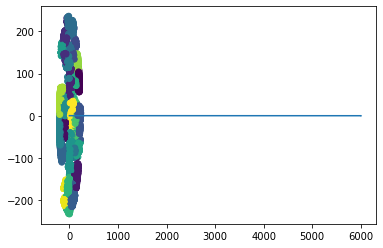

In [35]:
    # 5) Classification model

    #######################
    #    a) Dataprep to get the step 4 data into an appropriate format for prediction
    # TODO: Ensure that the step 4 output data is in the same format as the training_data dataframe (with the NRCan labels column as null for now)

    #    b)
    # TODO: Update read_csv() path to the correct location and file name for final product
    # TODO: Remove the train_test_split() code for final product
    # TODO: Ensure that the training_data dataframe is formated the same as the step 4 output (same as TODO for part a b/c it is that important)
    training_data=step4_data
#     training_data = pd.read_csv('~/data-599-capstone-ubc-urban-data-lab/code/step4_data.csv') # Reading in the training data file
    # Manipulating dataset to be in the appropriate format for creating seperate predictor and response datasets
    cols = training_data.columns.tolist()
    cols.remove('endUseLabel')
    cols.append('endUseLabel')
    training_data = training_data[cols]
    training_data = training_data.iloc[:,2:]
    training_data = training_data.fillna(0)
    # Extracting just the number from the label
    training_data['endUseLabel'] = training_data['endUseLabel'].apply(lambda x: int(str(x)[0:2]))
    training_data=training_data[(training_data['endUseLabel']!=99)]
    
    # Creating seperate predictor variable and response variable numpy arrays
    x = training_data.iloc[:, :-1].values
    y = training_data.iloc[:, -1].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0) ############### TEMP: For testing the model, remove for final product

    #    b) Create and train the selected model
    # Creating and fitting the classifier
    # TODO: Test various models and select a final model
    # TODO: Update model to the selected model (if not RandomForrestClassifier)
    # TODO: Change x_train and y_train to x and y once final model has been selcted
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini') # can include random_state=0 if we want to set the seed to be constant
    classifier.fit(x_train, y_train) # Can change x_train and y_train to just x and y for final model

    #    c) Predict the outputs for the new data
    # Predicting the outputs
    # TODO: Change x_test to whatever the numpy data to be predicted is (NOTE: Must have same format as the training_data dataframe)
    y_pred = classifier.predict(x_test) # TODO: Change x_test to whatever the actual data to be predicted's variable for final model

    ########################################################################################
    ############### TEMP: Used to test the effectiveness of the chosen model ###############
    ###############       To delete for the final model, just here so we can see some actual
    ###############       output from step 5
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    logloss = log_loss(y_true=y_test, y_pred=classifier.predict_proba(x_test))
    print("accuracy: "+str(accuracy))
    print("precision: "+str(precision))
    print("recall: "+str(recall))
    print("f1: "+str(f1))
    print("logloss: "+str(logloss))
    ############### TEMP: Used to test the effectiveness of the chosen model ###############
    ########################################################################################

    #    d) Join the predictions onto the  step 4 output dataframe
    # TODO: Join the predictions onto the step 4 output dataframe (or populate the NRCan column with these values)

    #    OUTPUT OF STEP = dataframe with EC sensor ID fields and end-use group

########################################################################################
############### TEMP: Used for calibrating dbscan and hdbscan clustering ###############
###############       Can delete once final model selection and calibration complete
###############                                     OR
###############       once dbscan AND hdbscan dismissed as possible models
from matplotlib import pyplot as plt
sorted_vals = gow_dist[0]
sorted_vals = sorted_vals[np.argsort(-gow_dist[0])]
plt.plot(sorted_vals)

testGow = pd.DataFrame(sorted_vals, columns=["values"])
testGow['values'].value_counts()#.sort_index()
############### TEMP: Used for calibrating dbscan and hdbscan clustering ###############
########################################################################################

##################################################################
############### TEMP: For visualizing the clusters ###############
###############       Can delete after moved to a seperate file
###############                             OR
###############       once desired plots have been obtained for
###############       the final report
from matplotlib import pyplot as plt
# Make Data into a Dataframe
data_2d_df = pd.DataFrame(data=mds_data, columns = ['x','y'])
data_2d_df['cluster'] = cluster_groups['cluster']

# Plotting the dbscan clusters (Fit pre-MDS)
plt.scatter(data_2d_df['x']*1000,data_2d_df['y']*1000, c=data_2d_df['cluster'])
############### TEMP: For visualizing the clusters ###############
##################################################################
